In [ ]:
%load_ext autoreload
%autoreload 2


from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 99999999999999


In [ ]:
x_data = Path('datasets/combo_001/lrup/')
y_data = Path('datasets/combo_001/hr')
y_tile = Path('datasets/tile_001/hr')
x_tile = Path('datasets/tile_001/lrup')


def my_crap(img):
    return img.copy()
    
    
tile_info =  build_tile_info(y_data, 512, 500, 100, 
                             skip_categories=['centrioles','neurons','ArgoSIMDL'])
generate_tiles(y_tile, tile_info, crap_dir=x_tile, crap_func=my_crap)

In [ ]:
crop_img

In [ ]:
tile_stuff.groupby('category').count()

In [ ]:
stats = file_data.groupby(['category','dims']).aggregate({'fsize': 'mean', 'name':'count'})
stats.columns = ['file_size', 'num']
stats

In [ ]:
files_by_cat = {}
for p in progress_bar(all_files):
    category = p.parts[-2]
    cat_list = files_by_cat.get(category, [])
    cat_list.append(p)
    files_by_cat[category] = cat_list

In [ ]:
def pull_random_tile_info(tile_sz):
    category=random.choice(list(files_by_cat.keys()))
    img_file=random.choice(files_by_cat[category])
    return {'category': category, 'fn': img_file, 'tile_sz': tile_sz}

In [ ]:
tile_sz = 1000
tile_infos = []
for i in range(1000):
    tile_infos.append(pull_random_tile_info(tile_sz))

In [ ]:
pd.DataFrame(tile_infos).groupby('category').count()

In [ ]:
from scipy.ndimage.interpolation import zoom as npzoom

def _micro_crappify(x, gauss_sigma = 1, poisson_loop=10, scale=4):
    x = x[0].numpy()
    x = x * 255.
    for n in range(poisson_loop):
        x = np.random.poisson(np.maximum(0,x).astype(np.int))
    x = x.astype(np.float32)
    noise = np.random.normal(0,gauss_sigma,size=x.shape).astype(np.float32)
    x = np.maximum(0,x+noise)
    x -= x.min()
    x /= x.max()
    return tensor(x[None])


class TfmEarly(Transform):
    "Decorator for pixel tfm funcs."
    order,_wrap = 0,'pixel'
micro_crappify = TfmEarly(_micro_crappify)




def get_src(x_data, y_data, size, zoom_scale=1.0, scale=1):
    def map_to_hr(x):
        return y_data/x.relative_to(x_data)
    tfms = [[],[]]
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    #tfms[0].insert(0, micro_crappify())
    
    src = (ImageImageList.from_folder(x_data)
           .split_by_folder()
           .label_from_func(map_to_hr)
           .transform(tfms, size=size)
           .transform_y(y_tfms, size=size*scale))
    return src


def get_data(src, **kwargs):
    data = src.databunch(**kwargs)
    data.c = 3
    return data


In [ ]:
src = get_src(x_data, y_data, size=128, zoom_scale=2, scale=1)
data = get_data(src, bs=4)
src

In [ ]:
model_dir = 'models'
arch = xresnet34
loss = F.l1_loss
metrics = sr_metrics
learn = xres_unet_learner(data, arch, path=Path('.'), loss_func=loss, metrics=metrics, model_dir=model_dir)


In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
import os

In [ ]:
all_files = []

for root,dirs,files in os.walk(y_data, topdown=False):
    all_files += files

In [ ]:
len(all_files)

In [2]:
img = PIL.Image.open('datasets/combo_001/hr/train/mitotracker/00_00_000001_MitoTracker Red FM 920x920 2min 01-Airyscan Processing-07.tif')

In [3]:
img = Image(pil2tensor(img, dtype=np.float32))

In [4]:
img

In [5]:
def noise_generator (noise_type,image):
    """
    Generate noise to a given Image based on required noise type
    
    Input parameters:
        image: ndarray (input image data. It will be converted to float)
        
        noise_type: string
            'gauss'        Gaussian-distrituion based noise
            'poission'     Poission-distribution based noise
            's&p'          Salt and Pepper noise, 0 or 1
            'speckle'      Multiplicative noise using out = image + n*image
                           where n is uniform noise with specified mean & variance
    """
    row,col,ch= image.shape
    if noise_type == "gauss":       
        mean = 0.0
        var = 0.01
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type =="speckle":
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image


from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import random_noise

def _micro_crappify(x, scale=4, PEAK=0.8):
    x = x[0].numpy()
    #x = (255.*x).astype(np.uint8)
    x = random_noise(x, mode='poisson')
    #x = npzoom(x, 1/scale, order=0)
    #x = x+np.random.poisson(x / 255.0 * PEAK) / PEAK * 255  
    #x = npzoom(x, scale, order=0)
    x -= x.min()
    x /= x.max()
    return tensor(x[None])


In [14]:
img2 = Image(tensor(noise_generator('poisson', img.data.numpy())))

In [15]:
img2

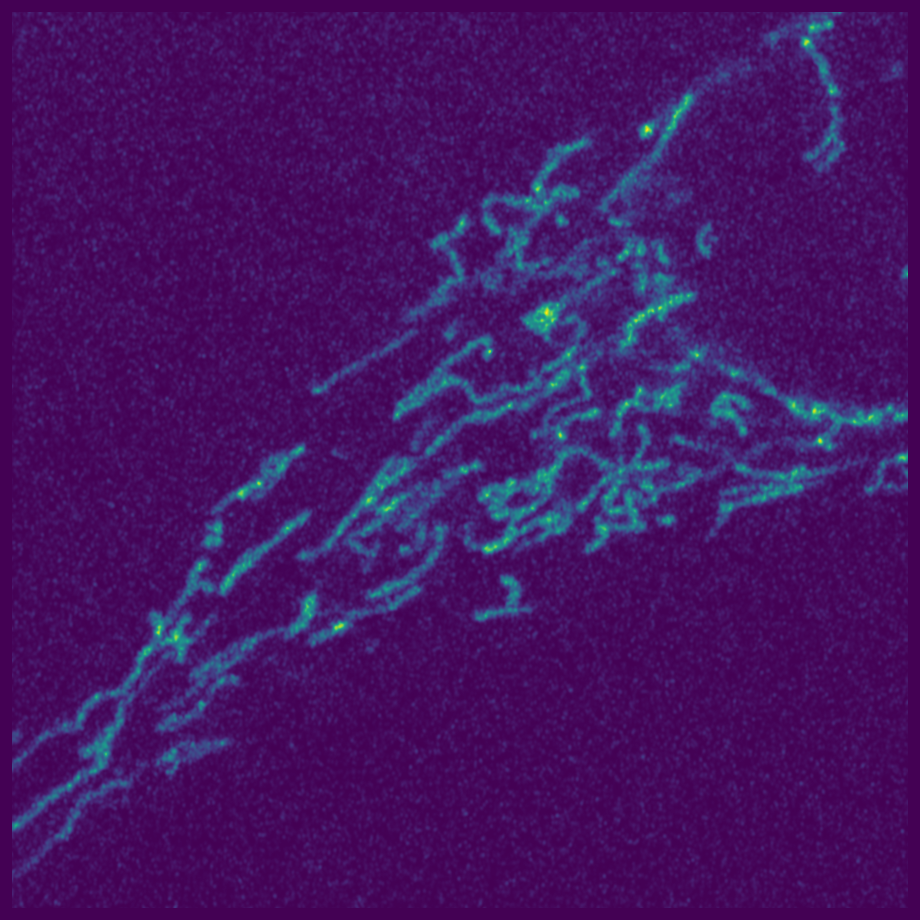

In [13]:
img